In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer


# Function to detect whether a column is continuous or categorical
def is_continuous(series):
    return pd.api.types.is_numeric_dtype(series) and series.nunique() > 10

# Function to determine if a column has too many unique values to be useful for plotting
def is_high_cardinality(series, threshold=20):
    return pd.api.types.is_string_dtype(series) and series.nunique() > threshold

# Function to plot the data in a grid layout, using stacked bar charts for categorical data
def plot_column_data(df):
    # Filter out columns with high cardinality
    columns_to_plot = [col for col in df.columns if not is_high_cardinality(df[col])]
    
    num_columns = len(columns_to_plot)
    cols = 3  # Number of charts per row
    rows = (num_columns // cols) + (num_columns % cols > 0)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for i, column in enumerate(columns_to_plot):
        ax = axes[i]
        
        if is_continuous(df[column]):
            # Plot stacked histograms for continuous data, split by survival
            bins = np.linspace(df[column].min(), df[column].max(), 20)
            ax.hist([df[df['Survived'] == 1][column].dropna(), df[df['Survived'] == 0][column].dropna()],
                    bins=bins, stacked=True, label=['Survived', 'Not Survived'], edgecolor='black')
            ax.set_title(f'{column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')
            ax.legend()
        else:
            # Plot stacked bar charts for categorical data, split by survival
            survived_counts = df[df['Survived'] == 1][column].value_counts()
            not_survived_counts = df[df['Survived'] == 0][column].value_counts()
            combined_counts = pd.DataFrame({'Survived': survived_counts, 'Not Survived': not_survived_counts}).fillna(0)
            
            combined_counts.plot(kind='bar', stacked=True, ax=ax, edgecolor='black')
            ax.set_title(f'{column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45)
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def impute_missing_data(df):

    # Use KNNImputer to fill missing age values based on nearest neighbors
    knn_imputer = KNNImputer(n_neighbors=5)
    df['Age'] = knn_imputer.fit_transform(df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']])

    # Fill missing Embarked values with the most frequent category (mode)
    most_frequent_embarked = df['Embarked'].mode()[0]
    df.fillna({'Embarked' : most_frequent_embarked}, inplace=True)
    # df['Embarked'].fillna(most_frequent_embarked, inplace=True)


def engineer_features(df):
    # Extract deck from cabin
    df['Deck'] = df['Cabin'].str[0]
    
    # Define deck mapping including 'T'
    deck_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 0}
    
    # Check for unmapped decks
    unmapped_decks = df['Deck'].dropna().unique()  # Get unique non-NaN deck values
    unmapped_decks = [deck for deck in unmapped_decks if deck not in deck_mapping]
    
    if unmapped_decks:
        raise ValueError(f"Unmapped decks found: {unmapped_decks}")
    
    # Create a binary feature for cabin presence (1 if Cabin is present, 0 if missing)
    df['Cabin_Present'] = df['Cabin'].notna().astype(int)
    
    # Map deck letters to ordinal values
    df['Deck_Level'] = df['Deck'].map(deck_mapping)
    
    # Fill missing deck levels with a new category (e.g., 8 for missing data)
    df['Deck_Level'] = df['Deck_Level'].fillna(8)

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # Add 1 to include the passenger themselves

    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    df['Title'] = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

    # Get value counts for each title
    title_counts = df['Title'].value_counts()

    # Identify titles that appear fewer than 10 times
    rare_titles = title_counts[title_counts < 10].index

    # Replace rare titles with 'Rare'
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')

    df['TicketFrequency'] = df.groupby('Ticket')['Ticket'].transform('count')

    df['FarePerPerson'] = df['Fare'] / df['TicketFrequency']

    df['AgeCategory'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teenager', 'Adult', 'Middle Aged', 'Senior'])

    df['Pclass_Sex'] = df['Pclass'].astype(str) + '_' + df['Sex']

    # Drop Cabin, Deck, and Name as they are no longer useful
    df.drop(columns=['Cabin', 'Deck', 'Name', 'Ticket'], inplace=True)
    

    
    return df


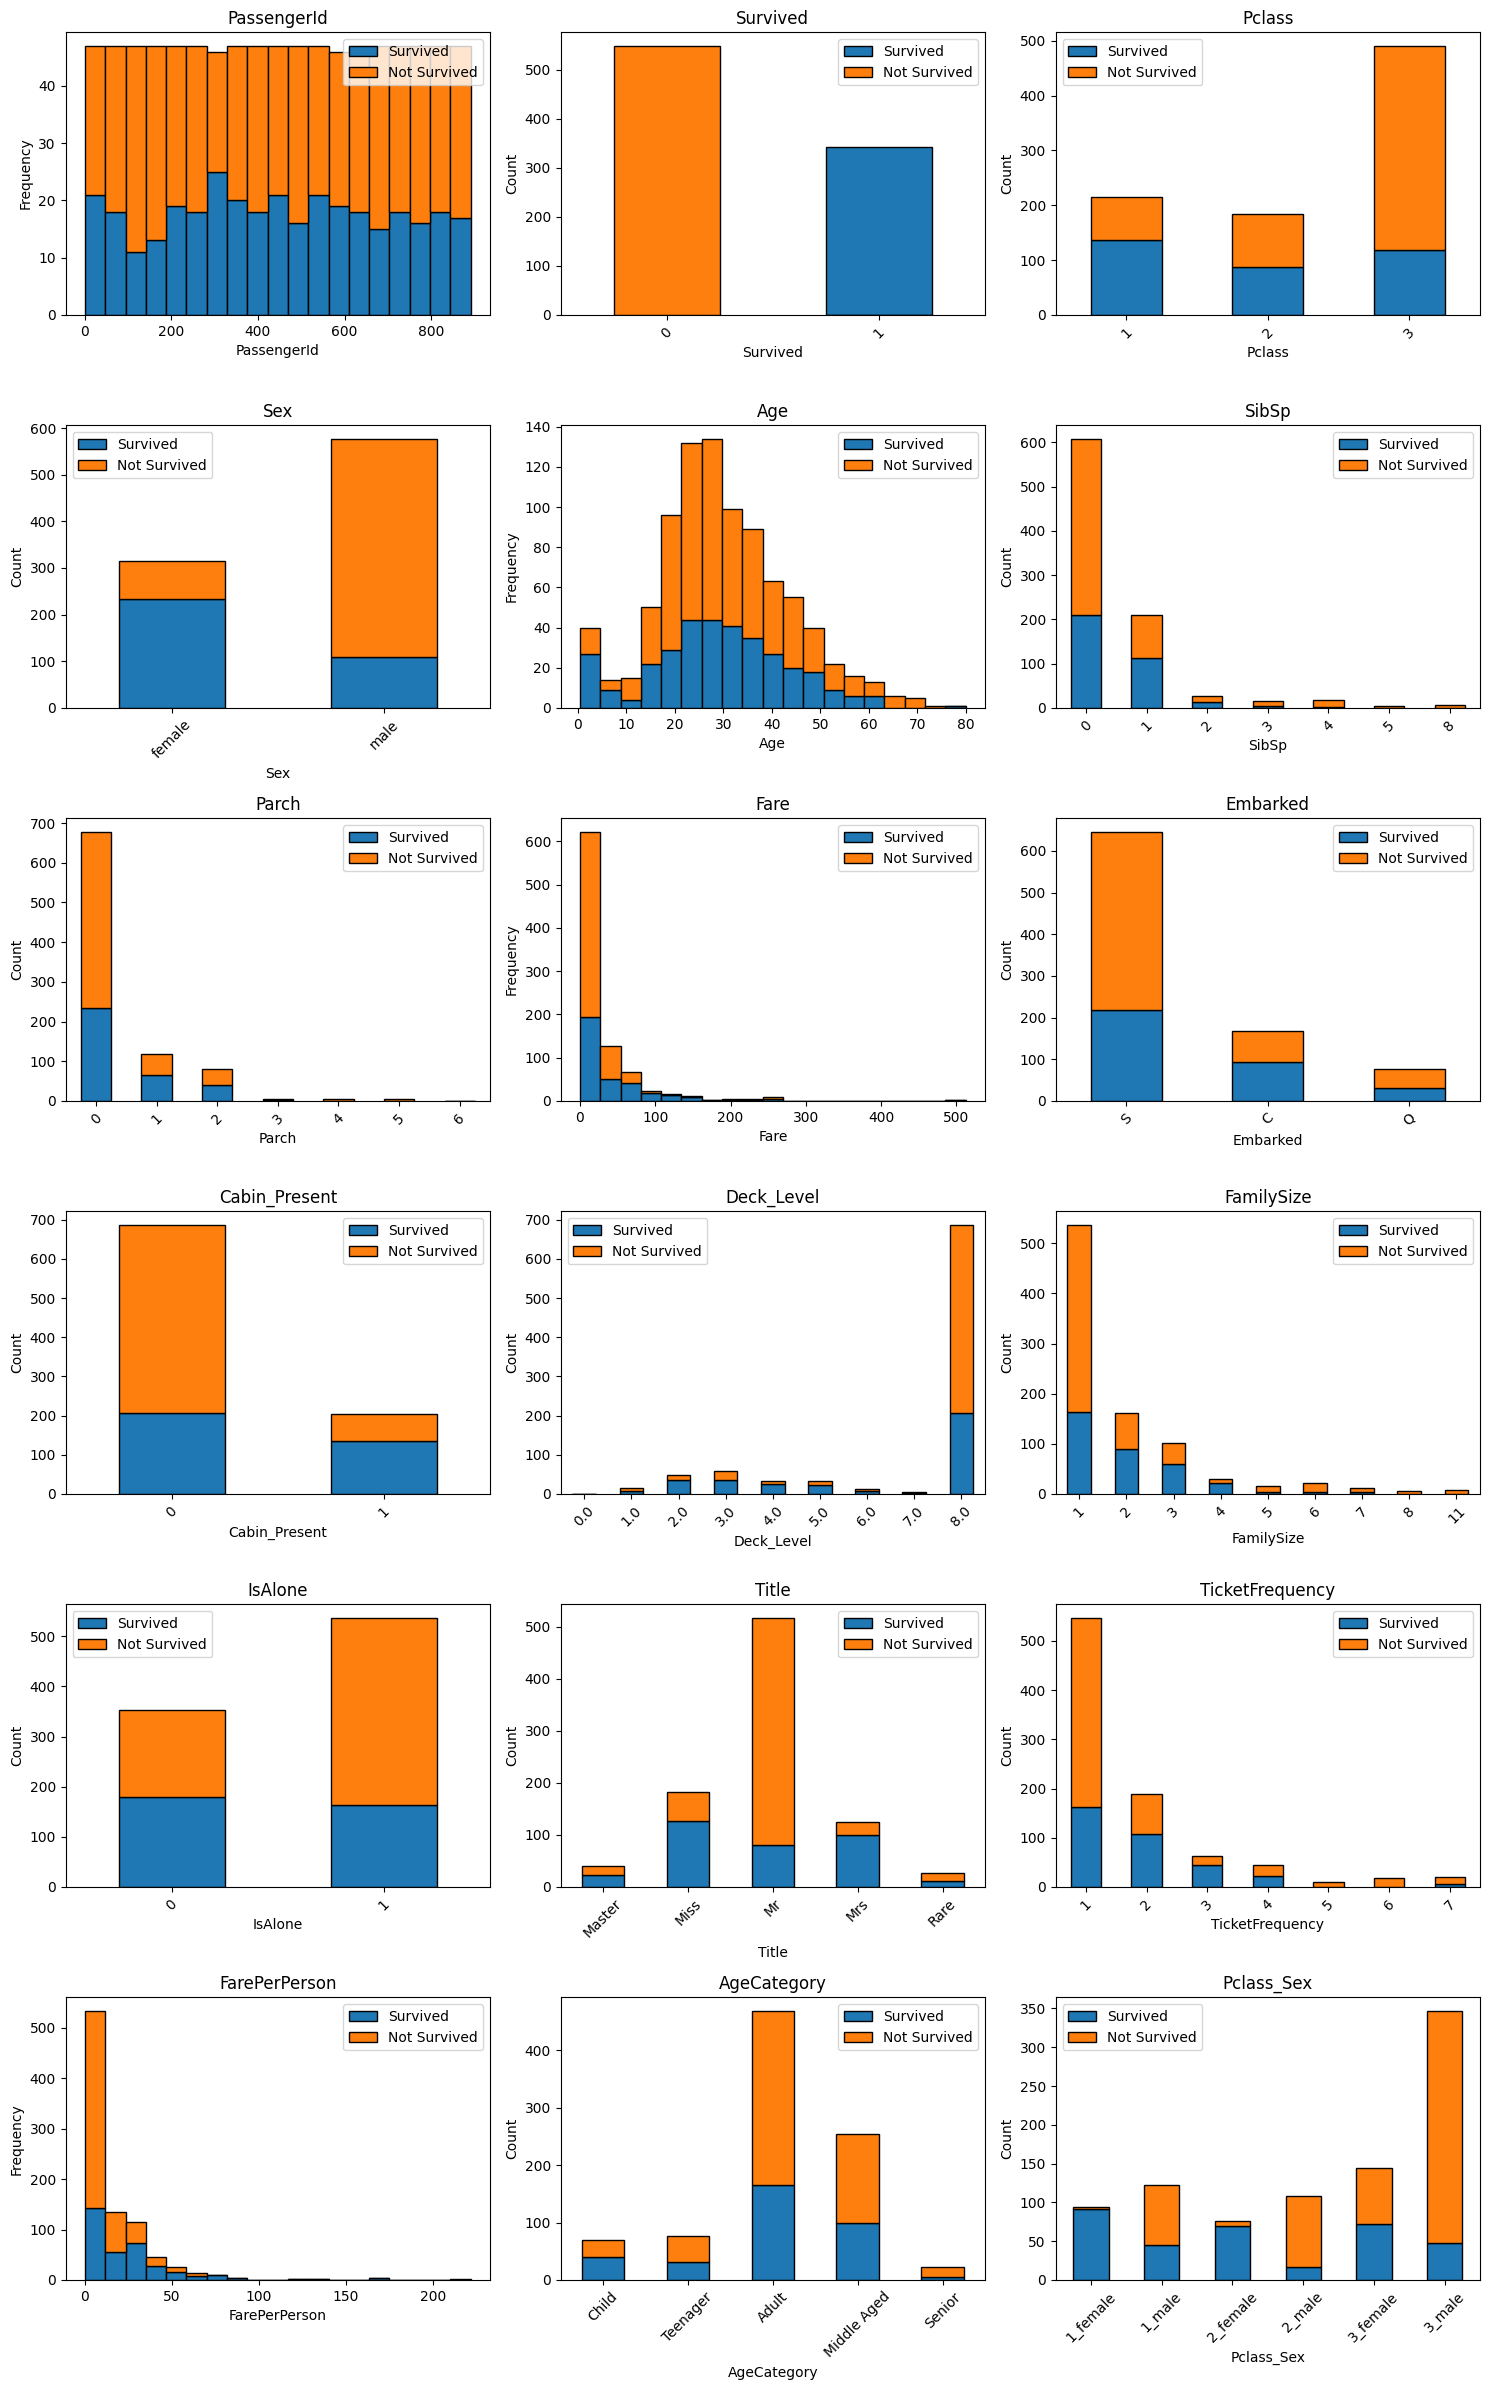

In [16]:
df = pd.read_csv('input/train.csv')
impute_missing_data(df)
engineer_features(df)
plot_column_data(df)

In [17]:
# Count missing values per column
missing_values_per_column = df.isnull().sum()

# Filter out columns with no missing values
missing_columns = missing_values_per_column[missing_values_per_column > 0]

# Display columns with missing values
print(missing_columns)


Series([], dtype: int64)


In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Assume df is your DataFrame
# Select the columns that need one-hot encoding (e.g., 'Sex', 'Title', 'Embarked')
categorical_features = ['Sex', 'Title', 'Embarked', 'AgeCategory', 'Pclass_Sex']

# Create the column transformer with OneHotEncoder for the selected features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ], remainder='passthrough')  # Leave the remaining columns as they are

# Apply the transformation
df_encoded = preprocessor.fit_transform(df)

# Convert the result back into a DataFrame
# OneHotEncoder returns a NumPy array, so we'll need to create a new DataFrame with appropriate column names
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
df_encoded = pd.DataFrame(df_encoded, columns=encoded_feature_names.tolist() + df.drop(columns=categorical_features).columns.tolist())

# Check the resulting DataFrame
print(df_encoded.head())


   Sex_male  Title_Miss  Title_Mr  Title_Mrs  Title_Rare  Embarked_Q  \
0       1.0         0.0       1.0        0.0         0.0         0.0   
1       0.0         0.0       0.0        1.0         0.0         0.0   
2       0.0         1.0       0.0        0.0         0.0         0.0   
3       0.0         0.0       0.0        1.0         0.0         0.0   
4       1.0         0.0       1.0        0.0         0.0         0.0   

   Embarked_S  AgeCategory_Child  AgeCategory_Middle Aged  AgeCategory_Senior  \
0         1.0                0.0                      0.0                 0.0   
1         0.0                0.0                      1.0                 0.0   
2         1.0                0.0                      0.0                 0.0   
3         1.0                0.0                      0.0                 0.0   
4         1.0                0.0                      0.0                 0.0   

   ...   Age  SibSp  Parch     Fare  Cabin_Present  Deck_Level  FamilySize  \
0 

In [19]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

# Assume df_encoded is your preprocessed DataFrame, and 'Survived' is the target
X = df_encoded.drop('Survived', axis=1)
y = df_encoded['Survived'].astype(int)


In [20]:
print(X.dtypes)

Sex_male                   float64
Title_Miss                 float64
Title_Mr                   float64
Title_Mrs                  float64
Title_Rare                 float64
Embarked_Q                 float64
Embarked_S                 float64
AgeCategory_Child          float64
AgeCategory_Middle Aged    float64
AgeCategory_Senior         float64
AgeCategory_Teenager       float64
Pclass_Sex_1_male          float64
Pclass_Sex_2_female        float64
Pclass_Sex_2_male          float64
Pclass_Sex_3_female        float64
Pclass_Sex_3_male          float64
PassengerId                float64
Pclass                     float64
Age                        float64
SibSp                      float64
Parch                      float64
Fare                       float64
Cabin_Present              float64
Deck_Level                 float64
FamilySize                 float64
IsAlone                    float64
TicketFrequency            float64
FarePerPerson              float64
dtype: object


In [21]:
print(y.dtypes)

int64


In [22]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the models with regularization
ridge_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))  # alpha is the regularization strength
])

lasso_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1))  # alpha is the regularization strength
])

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for Ridge Regression
ridge_cv_scores = cross_val_score(ridge_model, X, y, cv=cv, scoring='neg_mean_squared_error')

# Perform cross-validation for Lasso Regression
lasso_cv_scores = cross_val_score(lasso_model, X, y, cv=cv, scoring='neg_mean_squared_error')

# Convert negative MSE to positive values
ridge_cv_scores = -ridge_cv_scores
lasso_cv_scores = -lasso_cv_scores

# Print the cross-validation results
print(f'Ridge Regression Cross-Validation MSE Scores: {ridge_cv_scores}')
print(f'Mean Ridge Regression MSE: {ridge_cv_scores.mean():.4f}')

print(f'Lasso Regression Cross-Validation MSE Scores: {lasso_cv_scores}')
print(f'Mean Lasso Regression MSE: {lasso_cv_scores.mean():.4f}')


Ridge Regression Cross-Validation MSE Scores: [0.12938947 0.13091693 0.14002055 0.12812438 0.12695786]
Mean Ridge Regression MSE: 0.1311
Lasso Regression Cross-Validation MSE Scores: [0.16281728 0.16419695 0.16848579 0.16736814 0.15514954]
Mean Lasso Regression MSE: 0.1636


In [23]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids
ridge_param_grid = {'ridge__alpha': [0.1, 1.0, 10, 100]}
lasso_param_grid = {'lasso__alpha': [0.01, 0.1, 1.0, 10]}

# Perform GridSearchCV for Ridge
ridge_grid_search = GridSearchCV(ridge_model, ridge_param_grid, cv=cv, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X, y)

# Perform GridSearchCV for Lasso
lasso_grid_search = GridSearchCV(lasso_model, lasso_param_grid, cv=cv, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X, y)

# Best results
print(f"Best Ridge Alpha: {ridge_grid_search.best_params_['ridge__alpha']}")
print(f"Best Ridge MSE: {-ridge_grid_search.best_score_:.4f}")

print(f"Best Lasso Alpha: {lasso_grid_search.best_params_['lasso__alpha']}")
print(f"Best Lasso MSE: {-lasso_grid_search.best_score_:.4f}")


Best Ridge Alpha: 0.1
Best Ridge MSE: 0.1311
Best Lasso Alpha: 0.01
Best Lasso MSE: 0.1324


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for Random Forest
rf_cv_scores = cross_val_score(random_forest_model, X, y, cv=cv, scoring='neg_mean_squared_error')

# Convert negative MSE to positive values
rf_cv_scores = -rf_cv_scores

# Print the cross-validation results
print(f'Random Forest Cross-Validation MSE Scores: {rf_cv_scores}')
print(f'Mean Random Forest MSE: {rf_cv_scores.mean():.4f}')


Random Forest Cross-Validation MSE Scores: [0.1123514  0.13346854 0.15655281 0.13187528 0.12579045]
Mean Random Forest MSE: 0.1320


In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='neg_mean_squared_error')

# Convert negative MSE to positive values
xgb_cv_scores = -xgb_cv_scores

# Print the cross-validation results
print(f'XGBoost Cross-Validation MSE Scores: {xgb_cv_scores}')
print(f'Mean XGBoost MSE: {xgb_cv_scores.mean():.4f}')


XGBoost Cross-Validation MSE Scores: [0.10769872 0.14148607 0.16552419 0.14041637 0.1411926 ]
Mean XGBoost MSE: 0.1393


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for Random Forest
rf_cv_scores = cross_val_score(random_forest_model, X, y, cv=cv, scoring='neg_mean_squared_error')

# Convert negative MSE to positive values
rf_cv_scores = -rf_cv_scores

# Print the cross-validation results
print(f'Random Forest Cross-Validation MSE Scores: {rf_cv_scores}')
print(f'Mean Random Forest MSE: {rf_cv_scores.mean():.4f}')


Random Forest Cross-Validation MSE Scores: [0.1123514  0.13346854 0.15655281 0.13187528 0.12579045]
Mean Random Forest MSE: 0.1320


# Tensorflow

In [28]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Ensure X is a NumPy array
X = np.array(X)
y = np.array(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a basic neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer for regression (no activation)
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize list to store MSE for each fold
mse_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create a new instance of the model
    model = create_model()
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    # Evaluate the model
    mse = model.evaluate(X_test, y_test, verbose=0)
    mse_scores.append(mse)

# Print the cross-validation results
mse_scores = np.array(mse_scores)
print(f'Neural Network Cross-Validation MSE Scores: {mse_scores}')
print(f'Mean Neural Network MSE: {mse_scores.mean():.4f}')


/Users/franklevine/code/kaggle/titanic/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network Cross-Validation MSE Scores: [0.15977888 0.1779003  0.15277827 0.18292704 0.14073004]
Mean Neural Network MSE: 0.1628
